In [1]:
# ============================================
# Step 1: Weather data prep (expand missing dates)
# File: weather_missing_data.ipynb
# ============================================

import pandas as pd

# 1) Load raw weather file
wetter = pd.read_csv("wetter.csv")

# 2) Make sure the date column is datetime (and rename to 'date')
# Your file uses "Datum"
wetter["Datum"] = pd.to_datetime(wetter["Datum"], errors="coerce")
wetter = wetter.rename(columns={"Datum": "date"})

# 3) Basic checks
print("Rows (raw):", len(wetter))
print("Date range:", wetter["date"].min(), "→", wetter["date"].max())
print("Unique dates (raw):", wetter["date"].nunique())

# 4) Build a full daily calendar from min to max
full_dates = pd.date_range(start=wetter["date"].min(), end=wetter["date"].max(), freq="D")
calendar = pd.DataFrame({"date": full_dates})

# 5) Merge onto full calendar to INSERT missing dates as rows (NaNs in weather vars)
# If wetter has duplicates per date, aggregate first (keep first non-null / mean etc.)
# Here: we keep one row per date (first occurrence)
wetter_daily = (
    wetter.sort_values("date")
          .drop_duplicates(subset=["date"], keep="first")
)

wetter_expanded = calendar.merge(wetter_daily, on="date", how="left")

# 6) Detect missing dates (dates that were absent in the original wetter.csv)
missing_dates = calendar[~calendar["date"].isin(wetter_daily["date"])]

print("\nMissing dates inserted:", len(missing_dates))
print("Example missing dates:", missing_dates["date"].head(10).dt.strftime("%Y-%m-%d").tolist())

# 7) Missingness summary per column (after expanding)
print("\nMissing cells per column (expanded):")
print(wetter_expanded.isna().sum().sort_values(ascending=False))

# 8) Save expanded weather (still NOT imputed)
wetter_expanded.to_csv("wetter_expanded.csv", index=False, na_rep="NaN")
print("\nSaved: wetter_expanded.csv")


Rows (raw): 2601
Date range: 2012-01-01 00:00:00 → 2019-08-01 00:00:00
Unique dates (raw): 2601

Missing dates inserted: 169
Example missing dates: ['2012-07-24', '2012-10-06', '2012-10-07', '2012-10-13', '2012-10-14', '2012-10-20', '2012-10-21', '2012-10-27', '2012-10-28', '2012-11-03']

Missing cells per column (expanded):
Wettercode             838
Bewoelkung             179
Temperatur             169
Windgeschwindigkeit    169
date                     0
dtype: int64

Saved: wetter_expanded.csv


Missing cells per column (expanded):
date                     0
Bewoelkung             179
Temperatur             169
Windgeschwindigkeit    169
Wettercode             838
dtype: int64


<Figure size 1400x600 with 0 Axes>

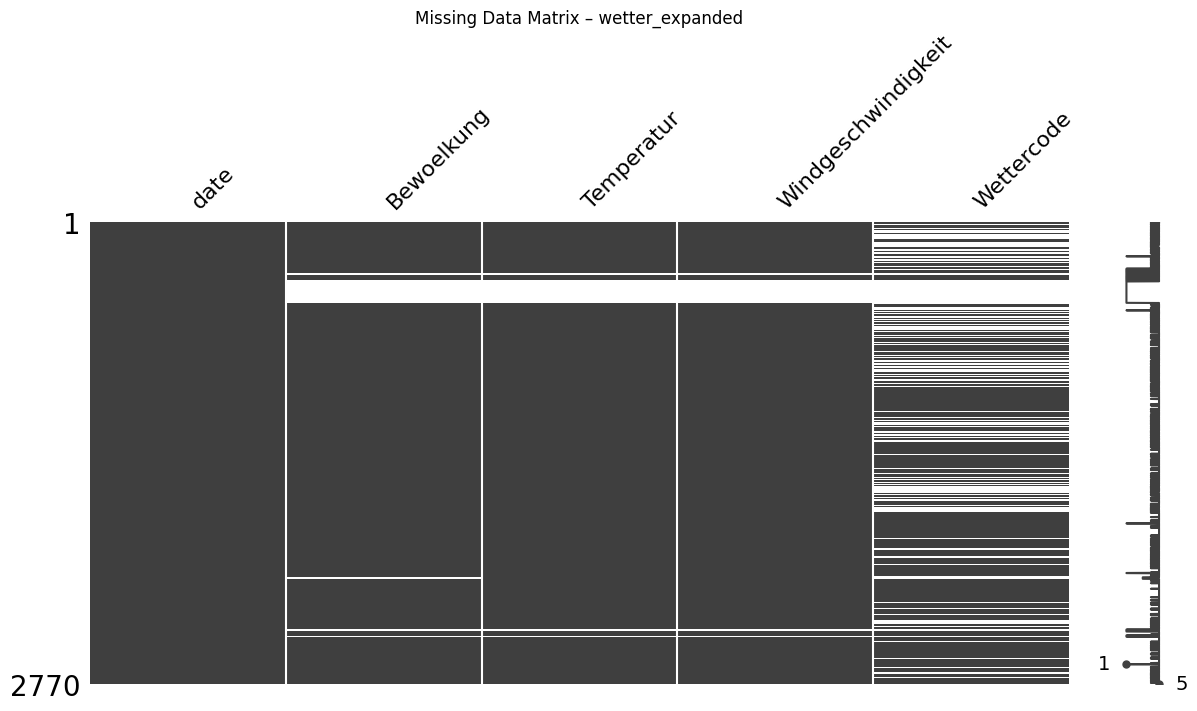

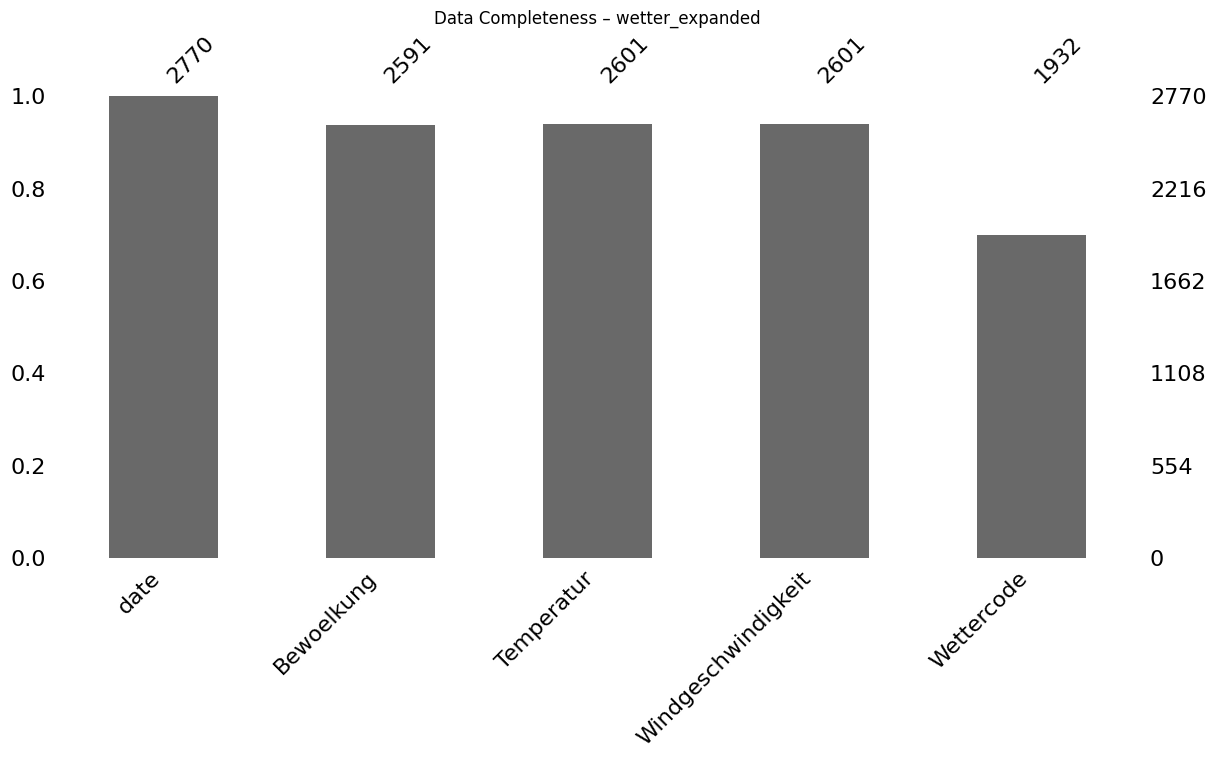

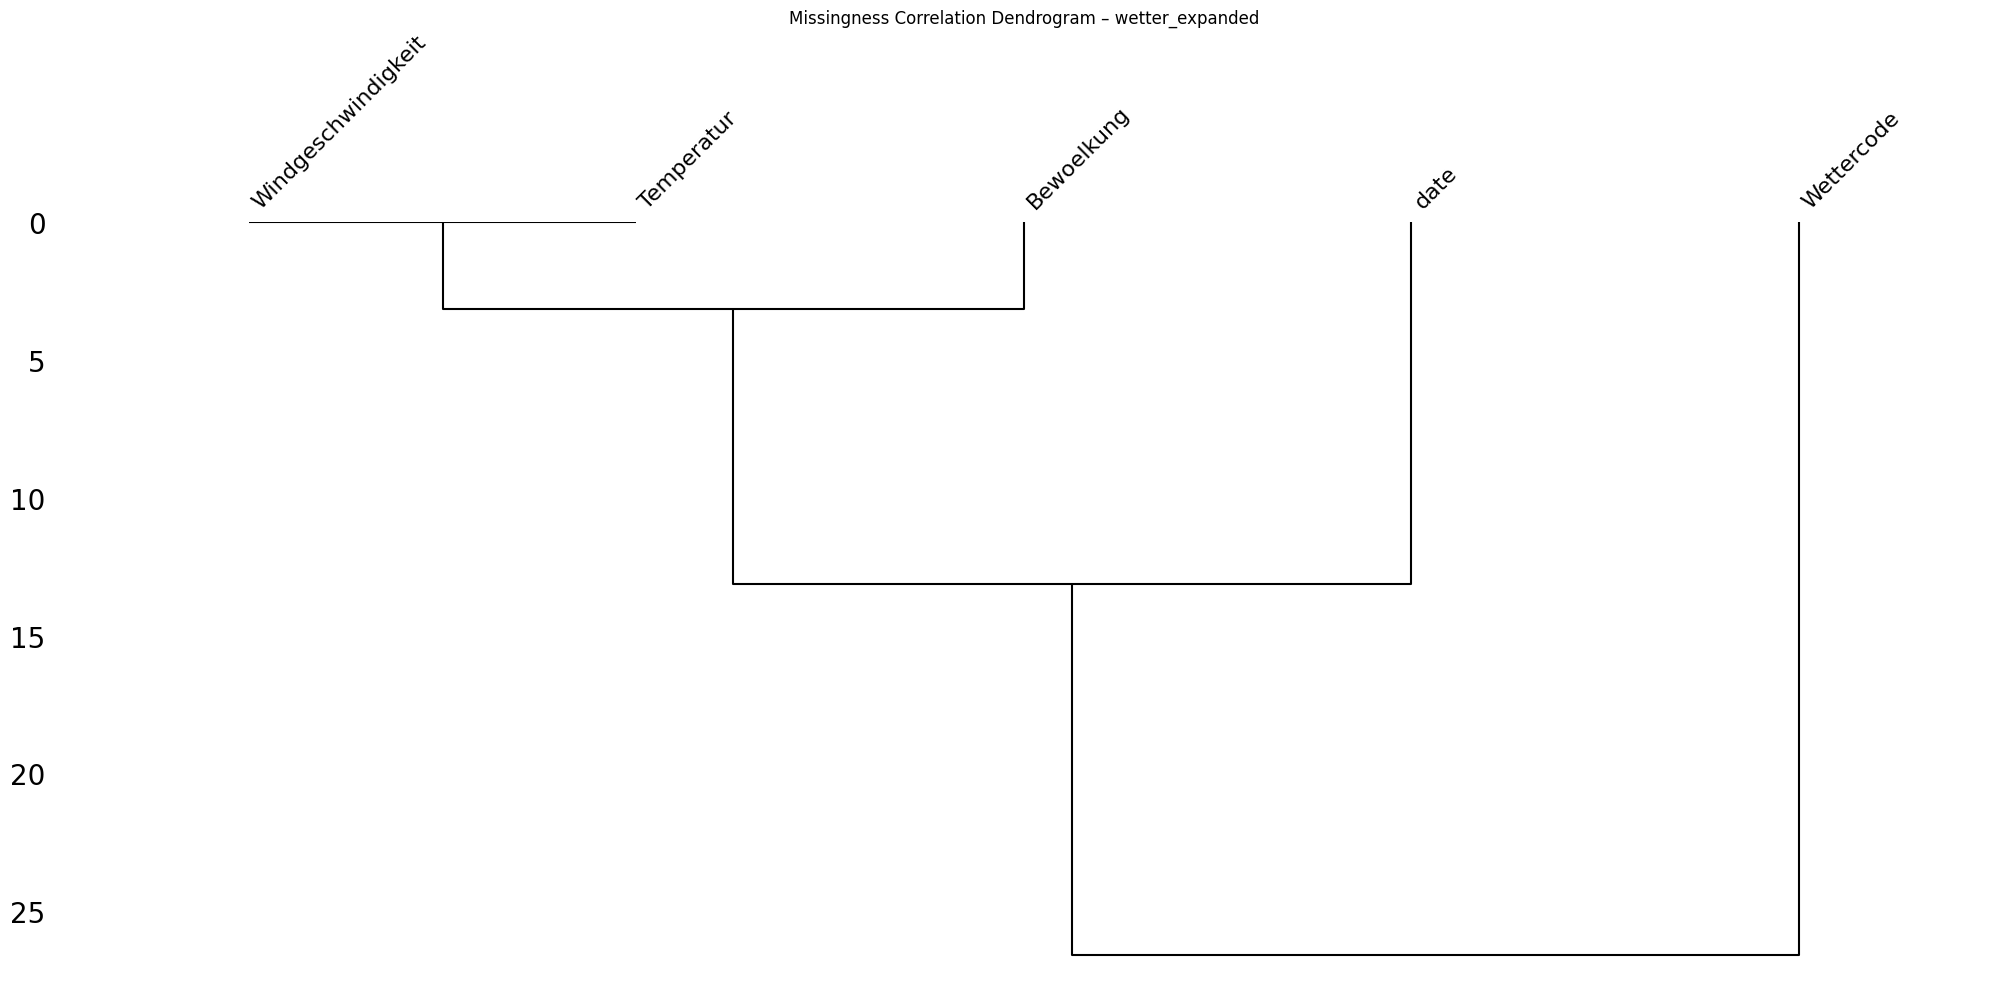

In [2]:
# ============================================
# Step 2: Visualize missingness (expanded)
# ============================================

import matplotlib.pyplot as plt
import missingno as msno

# If you're continuing in the same notebook, wetter_expanded already exists.
# Otherwise, uncomment:
# wetter_expanded = pd.read_csv("wetter_expanded.csv", parse_dates=["date"])

print("Missing cells per column (expanded):")
print(wetter_expanded.isna().sum())

plt.figure(figsize=(14, 6))
msno.matrix(wetter_expanded, figsize=(14, 6))
plt.title("Missing Data Matrix – wetter_expanded")
plt.show()

plt.figure(figsize=(14, 6))
msno.bar(wetter_expanded, figsize=(14, 6))
plt.title("Data Completeness – wetter_expanded")
plt.show()

msno.dendrogram(wetter_expanded)
plt.title("Missingness Correlation Dendrogram – wetter_expanded")
plt.show()


In [3]:
# ============================================
# Step 3: Imputation (lecture-style)
# - numeric: Temperatur, Windgeschwindigkeit (time interpolation)
# - Bewoelkung (0..8): interpolate + round/clip
# - Wettercode (00..99): time-based fill (ffill/bfill) + month-mode fallback
# Output: wetter_imputed.csv
# ============================================

import numpy as np

df = wetter_expanded.copy()
df = df.sort_values("date").reset_index(drop=True)

# Make sure numeric types are numeric
for col in ["Bewoelkung", "Temperatur", "Windgeschwindigkeit", "Wettercode"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.set_index("date")

# ---- 3A) Interpolation for continuous weather variables (time-based)
df["Temperatur"] = df["Temperatur"].interpolate(method="time", limit_direction="both")
df["Windgeschwindigkeit"] = df["Windgeschwindigkeit"].interpolate(method="time", limit_direction="both")

# Bewoelkung is discrete 0..8 -> interpolate, then round + clip
df["Bewoelkung"] = df["Bewoelkung"].interpolate(method="time", limit_direction="both")
df["Bewoelkung"] = df["Bewoelkung"].round(0).clip(0, 8)

# ---- 3B) Wettercode (categorical-ish numeric codes)
# First: continuity assumption for gaps -> forward/back fill
df["Wettercode"] = df["Wettercode"].ffill().bfill()

# Fallback: if any still missing (rare), use month-wise mode
if df["Wettercode"].isna().any():
    tmp = df.reset_index()
    tmp["month"] = tmp["date"].dt.month
    month_mode = (
        tmp.groupby("month")["Wettercode"]
           .agg(lambda s: s.dropna().mode().iloc[0] if not s.dropna().mode().empty else np.nan)
    )
    tmp["Wettercode"] = tmp["Wettercode"].fillna(tmp["month"].map(month_mode))
    # last fallback: global mode
    tmp["Wettercode"] = tmp["Wettercode"].fillna(tmp["Wettercode"].mode().iloc[0])
    df = tmp.drop(columns=["month"]).set_index("date")

# Make Wettercode integer-like 0..99
df["Wettercode"] = df["Wettercode"].round(0).clip(0, 99).astype("Int64")

df = df.reset_index()

print("Missing cells per column (after imputation):")
print(df.isna().sum())

df.to_csv("wetter_imputed.csv", index=False)
print("Saved: wetter_imputed.csv")

df.head()


Missing cells per column (after imputation):
date                   0
Bewoelkung             0
Temperatur             0
Windgeschwindigkeit    0
Wettercode             0
dtype: int64
Saved: wetter_imputed.csv


,date,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode
0,2012-01-01,8.0,9.8250,14.0,58
1,2012-01-02,7.0,7.4375,12.0,58
2,2012-01-03,8.0,5.5375,18.0,63
3,2012-01-04,4.0,5.6875,19.0,80
4,2012-01-05,6.0,5.3000,23.0,80


In [4]:
# ============================================
# Step 4 (quick check): compare before vs after
# ============================================

before = wetter_expanded.isna().sum()
after = df.isna().sum()

comparison = pd.DataFrame({"missing_before": before, "missing_after": after}).sort_values("missing_before", ascending=False)
comparison


,missing_before,missing_after
Wettercode,838,0
Bewoelkung,179,0
Temperatur,169,0
Windgeschwindigkeit,169,0
date,0,0
